# import library

In [1]:
import os
import sys
import time
import random
import argparse
import traceback

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as nfunc
from torch.nn.parameter import Parameter
from torch.utils.data import TensorDataset, DataLoader

gpu = "1"

os.environ["TF_CPP_MIN_LOG_LEVEL"] = '2'
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = gpu

# import model code

In [2]:
%load_ext autoreload
%autoreload 2

from ExpUtils import *

from torch_func.utils import set_framework_seed, weights_init_uniform, adjust_learning_rate
from torch_func.evaluate import evaluate_classifier
from torch_func.load_dataset import load_dataset
import torch_func.CNN as CNN
from torch_func.vat import VAT

# CNN model

In [3]:
# %load torch_func/CNN.py
import torch.nn as nn
import torch.nn.functional as nfunc

from torch_func.utils import call_bn


class CNN9c(nn.Module):
    """
    Ref: [VAT Chainer](https://github.com/takerum/vat_chainer/blob/master/models/cnn.py)
    [VAT TF[(https://github.com/takerum/vat_tf/blob/master/cnn.py)
    """
    def __init__(self, args):
        super(CNN9c, self).__init__()
        input_shape = (3, 32, 32)
        num_conv = 128
        affine = args.affine
        self.top_bn = args.top_bn
        self.dropout = args.drop
        # VAT Chainer CNN use bias, TF don't use bias
        self.c1 = nn.Conv2d(input_shape[0], num_conv, 3, 1, 1)
        self.c2 = nn.Conv2d(num_conv, num_conv, 3, 1, 1)
        self.c3 = nn.Conv2d(num_conv, num_conv, 3, 1, 1)
        self.c4 = nn.Conv2d(num_conv, num_conv * 2, 3, 1, 1)
        self.c5 = nn.Conv2d(num_conv * 2, num_conv * 2, 3, 1, 1)
        self.c6 = nn.Conv2d(num_conv * 2, num_conv * 2, 3, 1, 1)
        self.c7 = nn.Conv2d(num_conv * 2, num_conv * 4, 3, 1, 0)
        self.c8 = nn.Conv2d(num_conv * 4, num_conv * 2, 1, 1, 0)
        self.c9 = nn.Conv2d(num_conv * 2, 128, 1, 1, 0)
        # Chainer default eps=2e-05 [Chainer bn](https://docs.chainer.org/en/stable/reference/generated/chainer.links.BatchNormalization.html)
        self.bn1 = nn.BatchNorm2d(num_conv, affine=affine, eps=2e-05)
        self.bn2 = nn.BatchNorm2d(num_conv, affine=affine, eps=2e-05)
        self.bn3 = nn.BatchNorm2d(num_conv, affine=affine, eps=2e-05)
        self.bn4 = nn.BatchNorm2d(num_conv * 2, affine=affine, eps=2e-05)
        self.bn5 = nn.BatchNorm2d(num_conv * 2, affine=affine, eps=2e-05)
        self.bn6 = nn.BatchNorm2d(num_conv * 2, affine=affine, eps=2e-05)
        self.bn7 = nn.BatchNorm2d(num_conv * 4, affine=affine, eps=2e-05)
        self.bn8 = nn.BatchNorm2d(num_conv * 2, affine=affine, eps=2e-05)
        self.bn9 = nn.BatchNorm2d(num_conv, affine=affine, eps=2e-05)
        self.mp1 = nn.MaxPool2d(2, 2)
        self.mp2 = nn.MaxPool2d(2, 2)
        # Global average pooling, [batch_size, num_conv, ?, ?] -> [batch_size, num_conv, 1, 1]
        self.aap = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(128, 10)

        if self.dropout > 0:
            # make sure it's Dropout, not Dropout2d
            self.dp1 = nn.Dropout(self.dropout)
            self.dp2 = nn.Dropout(self.dropout)
        if self.top_bn:
            self.bnf = nn.BatchNorm1d(10, affine=affine, eps=2e-05)

    def forward(self, x, update_batch_stats=True, return_h=False):
        h = x
        endpoints = {}
        h = self.c1(h)
        h = nfunc.leaky_relu(call_bn(self.bn1, h, update_batch_stats=update_batch_stats), negative_slope=0.1)
        h = self.c2(h)
        h = nfunc.leaky_relu(call_bn(self.bn2, h, update_batch_stats=update_batch_stats), negative_slope=0.1)
        h = self.c3(h)
        h = nfunc.leaky_relu(call_bn(self.bn3, h, update_batch_stats=update_batch_stats), negative_slope=0.1)
        h = self.mp1(h)
        if self.dropout:
            h = self.dp1(h)
        endpoints["conv_layer0"] = h

        h = self.c4(h)
        h = nfunc.leaky_relu(call_bn(self.bn4, h, update_batch_stats=update_batch_stats), negative_slope=0.1)
        h = self.c5(h)
        h = nfunc.leaky_relu(call_bn(self.bn5, h, update_batch_stats=update_batch_stats), negative_slope=0.1)
        h = self.c6(h)
        h = nfunc.leaky_relu(call_bn(self.bn6, h, update_batch_stats=update_batch_stats), negative_slope=0.1)
        h = self.mp2(h)
        if self.dropout:
            h = self.dp2(h)
        endpoints["conv_layer1"] = h

        h = self.c7(h)
        h = nfunc.leaky_relu(call_bn(self.bn7, h, update_batch_stats=update_batch_stats), negative_slope=0.1)
        h = self.c8(h)
        h = nfunc.leaky_relu(call_bn(self.bn8, h, update_batch_stats=update_batch_stats), negative_slope=0.1)
        h = self.c9(h)
        h = nfunc.leaky_relu(call_bn(self.bn9, h, update_batch_stats=update_batch_stats), negative_slope=0.1)
        h = self.aap(h)
        endpoints["fc_layer0"] = h
        output = self.linear(h.view(-1, 128))

        if self.top_bn:
            output = call_bn(self.bnf, output, update_batch_stats=update_batch_stats)
        if return_h:
            return output, endpoints
        else:
            return output


# train code

In [4]:
def train(args):
    set_framework_seed(args.seed, args.debug)

    train_l, train_ul, test_set = load_dataset(args.data_dir, valid=False, dataset_seed=args.seed)
    wlog("N_train_labeled:{}, N_train_unlabeled:{}".format(train_l.N, train_ul.N))
    print("train data", train_l.data.sum())
    test_set = TensorDataset(torch.FloatTensor(test_set.data), torch.LongTensor(test_set.label))
    test_loader = DataLoader(test_set, 100, False)

    arch = getattr(CNN, args.arch)
    model = arch(args)
    if args.debug:
        # weights init is based on numpy, so only need np.random.seed()
        np.random.seed(args.seed)
        model.apply(weights_init_uniform)

    optimizer = optim.Adam(model.parameters(), lr=args.lr)

    start_epoch = 0

    model = model.to(args.device)
    model.train()

    accs_test = np.zeros(args.num_epochs)
    # Define losses.
    criterion = nn.CrossEntropyLoss()
    vat_criterion = VAT(args.device, eps=args.eps, xi=args.xi, use_ent_min=args.use_entmin, debug=args.debug)
    np.random.seed(1)
    for epoch in range(args.num_epochs):
        for it in range(args.num_batch_it):

            x, t = train_l.get(args.batchsize, aug_trans=args.aug_trans, aug_flip=args.aug_flip)

            images = torch.FloatTensor(x).to(args.device)
            labels = torch.LongTensor(t).to(args.device)
            logits = model(images)

            sup_loss = 0
            ul_loss = 0

            # supervised loss
            ce_loss = criterion(logits, labels)
            sup_loss += ce_loss

            if args.trainer == "mle":
                total_loss = sup_loss
            else:
                x_u, _ = train_ul.get(args.batchsize_ul, aug_trans=args.aug_trans, aug_flip=args.aug_flip)
                ul_images = torch.FloatTensor(x_u).to(args.device)
                ul_loss = vat_criterion(model, ul_images)
                total_loss = sup_loss + ul_loss

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()
            
        if epoch % 1 == 0 and it == args.num_batch_it - 1:
            print("x: %.5f" % x.sum())
            print("pytorch label loss %.7f" % sup_loss)
            n_err, test_loss = evaluate_classifier(model, test_loader, args.device)
            acc = 1 - n_err / len(test_set)
            print("Epoch %d, test acc: %.5f" % (epoch, acc))
            accs_test[epoch] = acc
    return accs_test

In [10]:
def parse_args():
    args = argparse.Namespace()
    args.dataset = "cifar10"
    args.trainer = "mle"
    args.lr = 0.001
    args.arch = "CNN9c"
    args.iterations = 1000
    args.seed = 1
    args.size = 100
    args.no_cuda = False
    
    # a large xi like 1e-4 will hurt the performance on MNIST
    # but even xi is 1e-1, the accuracy of CIFAR10 keeps the same
    args.xi = 1e-6
    args.eps = 10
    args.k = 1
    args.use_entmin = False
    args.alpha = 1
    args.mom1 = 0.9
    args.mom2 = 0.5
    args.reg_lamb = 1
    
    args.gpu_id = "1"
    args.log_dir = "log"
    args.n_categories = 10
    args.eval_freq = 1
    args.snapshot_freq = 20
    args.aug_flip = False
    args.aug_trans = False
    args.validation = False
    args.dataset_seed = 1
    args.batchsize = 32
    args.batchsize_ul = 128
    args.batchsize_eval = 100
    
    args.num_epochs = 50
    args.num_iter_per_epoch = 125
    args.num_batch_it = 125
    args.epoch_decay_start = 120
    args.method = "ce"
    args.epsilon = 10
    args.extra_lamb = 1
    
    args.drop = 0.5
    args.top_bn = False
    args.vis = False
    
    args.data_dir = os.path.join("./data/%s" % args.dataset)

    args.debug = True
    args.log_interval = 1
    args.affine = False
    args.cuda = not args.no_cuda and torch.cuda.is_available()
    device = torch.device("cuda" if args.cuda else "cpu")
    args.device = device
    return args

In [7]:
# pytorch
arg = parse_args()
arg.drop = 0.5
acc_list = train(arg)


2019-05-14 09:54:51,254 - <ipython-input-3-9b330eb74da9>[line:5]: N_train_labeled:4000, N_train_unlabeled:50000


train data -2591.2783
x: 92.79172
pytorch label loss 1.7741661
Epoch 0, test acc: 0.34040
x: -543.73975
pytorch label loss 1.2745868
Epoch 1, test acc: 0.45910
x: -60.15443
pytorch label loss 1.2494316
Epoch 2, test acc: 0.46230
x: 143.20457
pytorch label loss 0.9590910
Epoch 3, test acc: 0.42930
x: -101.98663
pytorch label loss 0.9446954
Epoch 4, test acc: 0.51030
x: 17.58744
pytorch label loss 0.9082096
Epoch 5, test acc: 0.53870
x: 161.68625
pytorch label loss 0.6502841
Epoch 6, test acc: 0.59160
x: 182.77206
pytorch label loss 0.9259822
Epoch 7, test acc: 0.61790
x: 584.95361
pytorch label loss 0.5094450
Epoch 8, test acc: 0.56890
x: -52.26637
pytorch label loss 0.6592411
Epoch 9, test acc: 0.55960
x: 33.64616
pytorch label loss 0.8124924
Epoch 10, test acc: 0.60680
x: 27.12246
pytorch label loss 0.6108854
Epoch 11, test acc: 0.61990
x: 461.10016
pytorch label loss 0.5733246
Epoch 12, test acc: 0.61520
x: -724.32178
pytorch label loss 0.3515632
Epoch 13, test acc: 0.61320
x: -455.9

In [8]:
# pytorch
arg.drop = 0.0
acc_05_list = train(arg)

2019-05-14 10:02:46,946 - <ipython-input-3-9b330eb74da9>[line:5]: N_train_labeled:4000, N_train_unlabeled:50000


train data -2591.2783
x: 92.79172
pytorch label loss 1.5453452
Epoch 0, test acc: 0.33040
x: -543.73975
pytorch label loss 1.1830873
Epoch 1, test acc: 0.30080
x: -60.15443
pytorch label loss 1.1114335
Epoch 2, test acc: 0.45430
x: 143.20457
pytorch label loss 0.8631876
Epoch 3, test acc: 0.52250
x: -101.98663
pytorch label loss 0.7341555
Epoch 4, test acc: 0.57190
x: 17.58744
pytorch label loss 0.5021304
Epoch 5, test acc: 0.52320
x: 161.68625
pytorch label loss 0.4496548
Epoch 6, test acc: 0.42930
x: 182.77206
pytorch label loss 0.7085162
Epoch 7, test acc: 0.51320
x: 584.95361
pytorch label loss 0.2585516
Epoch 8, test acc: 0.58410
x: -52.26637
pytorch label loss 0.3343198
Epoch 9, test acc: 0.54150
x: 33.64616
pytorch label loss 0.2910812
Epoch 10, test acc: 0.55910
x: 27.12246
pytorch label loss 0.2502673
Epoch 11, test acc: 0.51170
x: 461.10016
pytorch label loss 0.1484381
Epoch 12, test acc: 0.57940
x: -724.32178
pytorch label loss 0.0978856
Epoch 13, test acc: 0.61950
x: -455.9

2019-05-13 10:50:43,892 - <ipython-input-15-19c32b36ef1a>[line:5]: N_train_labeled:4000, N_train_unlabeled:50000


train data -2591.2783
x: -562.97064, x_u: 143.50818
pytorch label loss 2.2606215
x: 35.14433, x_u: 135.20184
pytorch label loss 2.4189808
x: -17.62558, x_u: 601.27460
pytorch label loss 2.2952368
x: -532.37256, x_u: 1750.79065
pytorch label loss 2.4121597
x: -70.22945, x_u: 347.33923
pytorch label loss 2.3319638
x: 56.61665, x_u: -1213.71118
pytorch label loss 2.3965092
x: -627.13055, x_u: -55.53556
pytorch label loss 2.4148233
x: -178.30162, x_u: -360.91476
pytorch label loss 2.4614964
x: -289.32187, x_u: 915.18994
pytorch label loss 2.4101825
x: -111.70967, x_u: -422.41815
pytorch label loss 2.3997018


2019-05-13 10:50:47,094 - <ipython-input-15-19c32b36ef1a>[line:61]: Epoch: 0 Train Loss: 2.3997 ce: 2.39970, vat: 0.00000, test loss: 2.40626, test acc: 0.1102


In [17]:
arg.drop = 0.5

acc_list = train(arg)

2019-05-13 10:52:04,452 - <ipython-input-15-19c32b36ef1a>[line:5]: N_train_labeled:4000, N_train_unlabeled:50000


train data -2591.2783
x: -562.97064, x_u: 143.50818
pytorch label loss 2.2750621
x: 35.14433, x_u: 135.20184
pytorch label loss 2.3824730
x: -17.62558, x_u: 601.27460
pytorch label loss 2.2932196
x: -532.37256, x_u: 1750.79065
pytorch label loss 2.3744545
x: -70.22945, x_u: 347.33923
pytorch label loss 2.3137186
x: 56.61665, x_u: -1213.71118
pytorch label loss 2.3670661
x: -627.13055, x_u: -55.53556
pytorch label loss 2.4136870
x: -178.30162, x_u: -360.91476
pytorch label loss 2.4105940
x: -289.32187, x_u: 915.18994
pytorch label loss 2.4110556
x: -111.70967, x_u: -422.41815
pytorch label loss 2.3749356


2019-05-13 10:52:07,670 - <ipython-input-15-19c32b36ef1a>[line:61]: Epoch: 0 Train Loss: 2.3749 ce: 2.37494, vat: 0.00000, test loss: 2.41538, test acc: 0.1142


In [24]:
arg.drop = 0.5

acc_list = train(arg)

2019-05-13 11:13:04,190 - <ipython-input-18-a06c9cede2be>[line:5]: N_train_labeled:4000, N_train_unlabeled:50000


train data -2591.2783
x: -562.97064, x_u: 143.50818
pytorch label loss 2.4099069
x: 35.14433, x_u: 135.20184
pytorch label loss 2.2265427
x: -17.62558, x_u: 601.27460
pytorch label loss 2.1924956
x: -532.37256, x_u: 1750.79065
pytorch label loss 2.3408909
x: -70.22945, x_u: 347.33923
pytorch label loss 2.2128272
x: 56.61665, x_u: -1213.71118
pytorch label loss 2.3133676
x: -627.13055, x_u: -55.53556
pytorch label loss 2.2681317
x: -178.30162, x_u: -360.91476
pytorch label loss 2.4872472
x: -289.32187, x_u: 915.18994
pytorch label loss 2.4417503
x: -111.70967, x_u: -422.41815
pytorch label loss 2.3514400


2019-05-13 11:13:06,699 - <ipython-input-18-a06c9cede2be>[line:61]: Epoch: 0 Train Loss: 2.3514 ce: 2.35144, vat: 0.00000, test loss: 2.31827, test acc: 0.1229


In [38]:
arg.drop = 0.5
acc_list = train(arg)

2019-05-13 11:44:08,047 - <ipython-input-37-ba4cbffe6c01>[line:5]: N_train_labeled:4000, N_train_unlabeled:50000


train data -2591.2783
x: -562.97064, x_u: 143.50818
pytorch label loss 2.2750621
test acc: 0.10000
x: -126.36263, x_u: 345.36444
pytorch label loss 2.1643209
test acc: 0.09940
x: 399.73303, x_u: -8.43586
pytorch label loss 2.1929793
test acc: 0.19810
x: 226.79512, x_u: 424.78540
pytorch label loss 2.0780790
test acc: 0.17450
x: 94.59266, x_u: -622.94928
pytorch label loss 1.5659134
test acc: 0.21560
x: 94.60011, x_u: -644.31439
pytorch label loss 1.4967724
test acc: 0.28310
x: 196.49091, x_u: 61.31622
pytorch label loss 1.7410563
test acc: 0.19080
x: -178.64716, x_u: -353.65878
pytorch label loss 1.5666623
test acc: 0.17340
x: 320.46967, x_u: -612.20245
pytorch label loss 1.8934345
test acc: 0.36530
x: 19.11314, x_u: -784.69800
pytorch label loss 1.7507118
test acc: 0.26760


In [39]:
arg.drop = 0.0
acc_list = train(arg)

2019-05-13 11:44:50,717 - <ipython-input-37-ba4cbffe6c01>[line:5]: N_train_labeled:4000, N_train_unlabeled:50000


train data -2591.2783
x: -562.97064, x_u: 143.50818
pytorch label loss 2.2606215
test acc: 0.10000
x: -126.36263, x_u: 345.36444
pytorch label loss 2.1652429
test acc: 0.13800
x: 399.73303, x_u: -8.43586
pytorch label loss 2.0234582
test acc: 0.15870
x: 226.79512, x_u: 424.78540
pytorch label loss 1.9177381
test acc: 0.27860
x: 94.59266, x_u: -622.94928
pytorch label loss 1.6000139
test acc: 0.12220
x: 94.60011, x_u: -644.31439
pytorch label loss 1.5202812
test acc: 0.31760
x: 196.49091, x_u: 61.31622
pytorch label loss 1.5974302
test acc: 0.30010
x: -178.64716, x_u: -353.65878
pytorch label loss 1.5880890
test acc: 0.22190
x: 320.46967, x_u: -612.20245
pytorch label loss 1.8056109
test acc: 0.33720
x: 19.11314, x_u: -784.69800
pytorch label loss 1.6236304
test acc: 0.30490


# full train

In [18]:
def train(args):
    set_framework_seed(args.seed, args.debug)

    train_l, train_ul, test_set = load_dataset(args.data_dir, valid=False, dataset_seed=args.seed)
    wlog("N_train_labeled:{}, N_train_unlabeled:{}".format(train_l.N, train_ul.N))
    print("train data", train_l.data.sum())
    test_set = TensorDataset(torch.FloatTensor(test_set.data), torch.LongTensor(test_set.label))
    test_loader = DataLoader(test_set, 128, False)

    arch = getattr(CNN, args.arch)
    model = arch(args)
    if args.debug:
        # weights init is based on numpy, so only need np.random.seed()
        np.random.seed(args.seed)
        model.apply(weights_init_normal)

    optimizer = optim.Adam(list(model.parameters()), lr=args.lr)

    start_epoch = 0

    model = model.to(args.device)
    model.train()

    # Define losses.
    criterion = nn.CrossEntropyLoss()
    vat_criterion = VAT(args.device, eps=args.eps, xi=args.xi, use_ent_min=args.ent_min, debug=args.debug)

    start = time.time()
    acc_list = []
    for epoch in range(args.num_epochs):

        sum_loss_l = 0
        sum_loss_ul = 0
        for it in range(args.num_batch_it):
            x, t = train_l.get(args.batchsize, aug_trans=args.aug_trans, aug_flip=args.aug_flip)
            x_u, _ = train_ul.get(args.batchsize_ul, aug_trans=args.aug_trans, aug_flip=args.aug_flip)
            
            images = torch.FloatTensor(x).to(args.device)
            labels = torch.LongTensor(t).to(args.device)
            ul_images = torch.FloatTensor(x_u).to(args.device)

            logits = model(images)

            sup_loss = 0
            ul_loss = 0

            # supervised loss
            ce_loss = criterion(logits, labels)
            sup_loss += ce_loss

            if args.trainer == "mle":
                total_loss = sup_loss
            else:
                ul_loss = vat_criterion(model, ul_images)
                total_loss = sup_loss + ul_loss

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            if ((epoch % args.log_interval) == 0 and it == args.num_batch_it - 1) or (args.debug and it < 50):
                n_err, test_loss = evaluate_classifier(model, test_loader, args.device)
                acc = 1 - n_err / len(test_set)
                wlog("Epoch: %d Train Loss: %.4f ce: %.5f, vat: %.5f, test loss: %.5f, test acc: %.4f" % (epoch, total_loss, ce_loss, ul_loss, test_loss, acc))

                pred_y = torch.max(logits, dim=1)[1]
                train_acc = 1.0 * torch.sum(pred_y == labels).item() / pred_y.shape[0]
                acc_list.append(acc)

        lr = adjust_learning_rate(optimizer, epoch, args)
        if (epoch % args.log_interval) == 0:
            wlog("learning rate %f" % lr)
            if args.vis:
                args.writer.add_scalar("optimizer/learning_rate", lr, epoch)
    return acc_list

# train with dropout=0.5

In [9]:
def parse_args():
    args = argparse.Namespace()
    args.dataset = "cifar10"
    args.trainer = "mle"
    args.lr = 0.001
    args.arch = "CNN9c"
    args.iterations = 1000
    args.seed = 1
    args.size = 100
    args.no_cuda = False
    
    args.xi = 1e-6
    args.eps = 10
    args.k = 1
    args.use_entmin = False
    args.alpha = 1
    args.mom1 = 0.9
    args.mom2 = 0.5
    args.reg_lamb = 1
    args.affine = False
    args.ent_min = False
    
    args.gpu_id = "1"
    args.log_dir = "log"
    args.n_categories = 10
    args.eval_freq = 1
    args.log_interval = 1
    args.snapshot_freq = 20
    args.aug_flip = False
    args.aug_trans = False
    args.validation = False
    args.dataset_seed = 1
    args.batchsize = 32
    args.batchsize_ul = 128
    args.batchsize_eval = 100
    
    args.num_epochs = 200
    args.num_iter_per_epoch = 400
    args.num_batch_it = 400
    args.epoch_decay_start = 120
    args.method = "vat"
    args.epsilon = 10
    args.extra_lamb = 1
    
    args.drop = 0.5
    args.top_bn = False
    args.vis = False
    args.debug = False
    args.data_dir = os.path.join("./data/%s" % args.dataset)

    args.cuda = not args.no_cuda and torch.cuda.is_available()
    device = torch.device("cuda" if args.cuda else "cpu")
    args.device = device
    return args

arg = parse_args()
arg.exp = "avg"

wlog("args in this experiment %s", '\n'.join(str(e) for e in sorted(vars(arg).items())))
# noinspection PyBroadException

acc_list = train(arg)


2019-05-12 22:35:29,387 - <ipython-input-9-672506e2b4d7>[line:59]: args in this experiment ('affine', False)
('alpha', 1)
('arch', 'CNN9c')
('aug_flip', False)
('aug_trans', False)
('batchsize', 32)
('batchsize_eval', 100)
('batchsize_ul', 128)
('cuda', True)
('data_dir', './data/cifar10')
('dataset', 'cifar10')
('dataset_seed', 1)
('debug', False)
('device', device(type='cuda'))
('drop', 0.5)
('ent_min', False)
('epoch_decay_start', 120)
('eps', 10)
('epsilon', 10)
('eval_freq', 1)
('exp', 'avg')
('extra_lamb', 1)
('gpu_id', '1')
('iterations', 1000)
('k', 1)
('log_dir', 'log')
('log_interval', 1)
('lr', 0.001)
('method', 'vat')
('mom1', 0.9)
('mom2', 0.5)
('n_categories', 10)
('no_cuda', False)
('num_batch_it', 400)
('num_epochs', 200)
('num_iter_per_epoch', 400)
('reg_lamb', 1)
('seed', 1)
('size', 100)
('snapshot_freq', 20)
('top_bn', False)
('trainer', 'mle')
('use_entmin', False)
('validation', False)
('vis', False)
('xi', 1e-06)
2019-05-12 22:35:31,136 - <ipython-input-7-bdc23bc

train data -2591.2783


2019-05-12 22:35:43,542 - <ipython-input-7-bdc23bc4b139>[line:64]: Epoch: 0 Train Loss: 1.6884 ce: 1.68835, vat: 0.00000, test loss: 1.78299, test acc: 0.3209
2019-05-12 22:35:43,544 - <ipython-input-7-bdc23bc4b139>[line:72]: learning rate 0.001000
2019-05-12 22:35:50,309 - <ipython-input-7-bdc23bc4b139>[line:64]: Epoch: 1 Train Loss: 1.5572 ce: 1.55722, vat: 0.00000, test loss: 1.42607, test acc: 0.4810
2019-05-12 22:35:50,310 - <ipython-input-7-bdc23bc4b139>[line:72]: learning rate 0.001000
2019-05-12 22:35:57,267 - <ipython-input-7-bdc23bc4b139>[line:64]: Epoch: 2 Train Loss: 1.1066 ce: 1.10659, vat: 0.00000, test loss: 1.31845, test acc: 0.5136
2019-05-12 22:35:57,269 - <ipython-input-7-bdc23bc4b139>[line:72]: learning rate 0.001000
2019-05-12 22:36:04,277 - <ipython-input-7-bdc23bc4b139>[line:64]: Epoch: 3 Train Loss: 1.0479 ce: 1.04791, vat: 0.00000, test loss: 1.26523, test acc: 0.5492
2019-05-12 22:36:04,282 - <ipython-input-7-bdc23bc4b139>[line:72]: learning rate 0.001000
2019

2019-05-12 22:39:17,963 - <ipython-input-7-bdc23bc4b139>[line:64]: Epoch: 33 Train Loss: 0.0163 ce: 0.01634, vat: 0.00000, test loss: 1.79781, test acc: 0.6529
2019-05-12 22:39:17,965 - <ipython-input-7-bdc23bc4b139>[line:72]: learning rate 0.001000
2019-05-12 22:39:24,244 - <ipython-input-7-bdc23bc4b139>[line:64]: Epoch: 34 Train Loss: 0.0167 ce: 0.01667, vat: 0.00000, test loss: 1.55125, test acc: 0.6869
2019-05-12 22:39:24,245 - <ipython-input-7-bdc23bc4b139>[line:72]: learning rate 0.001000
2019-05-12 22:39:30,508 - <ipython-input-7-bdc23bc4b139>[line:64]: Epoch: 35 Train Loss: 0.0232 ce: 0.02317, vat: 0.00000, test loss: 2.08963, test acc: 0.6192
2019-05-12 22:39:30,509 - <ipython-input-7-bdc23bc4b139>[line:72]: learning rate 0.001000
2019-05-12 22:39:36,834 - <ipython-input-7-bdc23bc4b139>[line:64]: Epoch: 36 Train Loss: 0.0839 ce: 0.08388, vat: 0.00000, test loss: 1.53061, test acc: 0.6839
2019-05-12 22:39:36,835 - <ipython-input-7-bdc23bc4b139>[line:72]: learning rate 0.001000


2019-05-12 22:42:47,626 - <ipython-input-7-bdc23bc4b139>[line:64]: Epoch: 66 Train Loss: 0.0045 ce: 0.00445, vat: 0.00000, test loss: 1.88496, test acc: 0.6691
2019-05-12 22:42:47,627 - <ipython-input-7-bdc23bc4b139>[line:72]: learning rate 0.001000
2019-05-12 22:42:54,012 - <ipython-input-7-bdc23bc4b139>[line:64]: Epoch: 67 Train Loss: 0.0033 ce: 0.00326, vat: 0.00000, test loss: 1.70542, test acc: 0.6961
2019-05-12 22:42:54,014 - <ipython-input-7-bdc23bc4b139>[line:72]: learning rate 0.001000
2019-05-12 22:43:00,281 - <ipython-input-7-bdc23bc4b139>[line:64]: Epoch: 68 Train Loss: 0.0025 ce: 0.00249, vat: 0.00000, test loss: 1.95200, test acc: 0.6754
2019-05-12 22:43:00,283 - <ipython-input-7-bdc23bc4b139>[line:72]: learning rate 0.001000
2019-05-12 22:43:06,666 - <ipython-input-7-bdc23bc4b139>[line:64]: Epoch: 69 Train Loss: 0.0445 ce: 0.04455, vat: 0.00000, test loss: 1.78753, test acc: 0.6803
2019-05-12 22:43:06,667 - <ipython-input-7-bdc23bc4b139>[line:72]: learning rate 0.001000


2019-05-12 22:46:17,100 - <ipython-input-7-bdc23bc4b139>[line:64]: Epoch: 99 Train Loss: 0.0468 ce: 0.04678, vat: 0.00000, test loss: 1.95112, test acc: 0.6864
2019-05-12 22:46:17,102 - <ipython-input-7-bdc23bc4b139>[line:72]: learning rate 0.001000
2019-05-12 22:46:23,438 - <ipython-input-7-bdc23bc4b139>[line:64]: Epoch: 100 Train Loss: 0.0021 ce: 0.00206, vat: 0.00000, test loss: 1.82572, test acc: 0.7011
2019-05-12 22:46:23,440 - <ipython-input-7-bdc23bc4b139>[line:72]: learning rate 0.001000
2019-05-12 22:46:29,833 - <ipython-input-7-bdc23bc4b139>[line:64]: Epoch: 101 Train Loss: 0.0020 ce: 0.00200, vat: 0.00000, test loss: 1.94584, test acc: 0.6791
2019-05-12 22:46:29,835 - <ipython-input-7-bdc23bc4b139>[line:72]: learning rate 0.001000
2019-05-12 22:46:36,238 - <ipython-input-7-bdc23bc4b139>[line:64]: Epoch: 102 Train Loss: 0.0063 ce: 0.00632, vat: 0.00000, test loss: 1.77183, test acc: 0.6997
2019-05-12 22:46:36,239 - <ipython-input-7-bdc23bc4b139>[line:72]: learning rate 0.0010

2019-05-12 22:49:55,710 - <ipython-input-7-bdc23bc4b139>[line:64]: Epoch: 132 Train Loss: 0.0128 ce: 0.01283, vat: 0.00000, test loss: 1.80345, test acc: 0.7056
2019-05-12 22:49:55,717 - <ipython-input-7-bdc23bc4b139>[line:72]: learning rate 0.000850
2019-05-12 22:50:05,294 - <ipython-input-7-bdc23bc4b139>[line:64]: Epoch: 133 Train Loss: 0.0040 ce: 0.00401, vat: 0.00000, test loss: 1.88455, test acc: 0.7041
2019-05-12 22:50:05,308 - <ipython-input-7-bdc23bc4b139>[line:72]: learning rate 0.000838
2019-05-12 22:50:15,574 - <ipython-input-7-bdc23bc4b139>[line:64]: Epoch: 134 Train Loss: 0.0048 ce: 0.00477, vat: 0.00000, test loss: 1.73273, test acc: 0.7137
2019-05-12 22:50:15,587 - <ipython-input-7-bdc23bc4b139>[line:72]: learning rate 0.000825
2019-05-12 22:50:24,819 - <ipython-input-7-bdc23bc4b139>[line:64]: Epoch: 135 Train Loss: 0.0010 ce: 0.00099, vat: 0.00000, test loss: 1.79238, test acc: 0.7089
2019-05-12 22:50:24,826 - <ipython-input-7-bdc23bc4b139>[line:72]: learning rate 0.000

2019-05-12 22:54:03,364 - <ipython-input-7-bdc23bc4b139>[line:72]: learning rate 0.000450
2019-05-12 22:54:11,111 - <ipython-input-7-bdc23bc4b139>[line:64]: Epoch: 165 Train Loss: 0.0002 ce: 0.00018, vat: 0.00000, test loss: 1.87161, test acc: 0.7182
2019-05-12 22:54:11,112 - <ipython-input-7-bdc23bc4b139>[line:72]: learning rate 0.000438
2019-05-12 22:54:20,399 - <ipython-input-7-bdc23bc4b139>[line:64]: Epoch: 166 Train Loss: 0.0005 ce: 0.00046, vat: 0.00000, test loss: 1.82611, test acc: 0.7208
2019-05-12 22:54:20,400 - <ipython-input-7-bdc23bc4b139>[line:72]: learning rate 0.000425
2019-05-12 22:54:29,837 - <ipython-input-7-bdc23bc4b139>[line:64]: Epoch: 167 Train Loss: 0.0027 ce: 0.00274, vat: 0.00000, test loss: 1.86158, test acc: 0.7122
2019-05-12 22:54:29,838 - <ipython-input-7-bdc23bc4b139>[line:72]: learning rate 0.000412
2019-05-12 22:54:39,733 - <ipython-input-7-bdc23bc4b139>[line:64]: Epoch: 168 Train Loss: 0.0044 ce: 0.00437, vat: 0.00000, test loss: 1.84648, test acc: 0.7

2019-05-12 22:58:43,935 - <ipython-input-7-bdc23bc4b139>[line:72]: learning rate 0.000037
2019-05-12 22:58:53,701 - <ipython-input-7-bdc23bc4b139>[line:64]: Epoch: 198 Train Loss: 0.0000 ce: 0.00001, vat: 0.00000, test loss: 1.82305, test acc: 0.7319
2019-05-12 22:58:53,703 - <ipython-input-7-bdc23bc4b139>[line:72]: learning rate 0.000025
2019-05-12 22:59:02,877 - <ipython-input-7-bdc23bc4b139>[line:64]: Epoch: 199 Train Loss: 0.0001 ce: 0.00005, vat: 0.00000, test loss: 1.85397, test acc: 0.7297
2019-05-12 22:59:02,882 - <ipython-input-7-bdc23bc4b139>[line:72]: learning rate 0.000013


# train with dropout=0.0

In [15]:

arg.exp = "avg"
arg.dropout_rate = 0.0

wlog("args in this experiment %s", '\n'.join(str(e) for e in sorted(vars(arg).items())))
# noinspection PyBroadException

acc_z_list = train(arg)


2019-05-12 23:29:57,903 - <ipython-input-15-c475fea2cf72>[line:5]: args in this experiment ('affine', False)
('alpha', 1)
('arch', 'CNN9c')
('aug_flip', False)
('aug_trans', False)
('batchsize', 32)
('batchsize_eval', 100)
('batchsize_ul', 128)
('cuda', True)
('data_dir', './data/cifar10')
('dataset', 'cifar10')
('dataset_seed', 1)
('debug', False)
('device', device(type='cuda'))
('drop', 0.5)
('dropout_rate', 0.0)
('ent_min', False)
('epoch_decay_start', 120)
('eps', 10)
('epsilon', 10)
('eval_freq', 1)
('exp', 'avg')
('extra_lamb', 1)
('gpu_id', '1')
('iterations', 1000)
('k', 1)
('log_dir', 'log')
('log_interval', 1)
('lr', 0.001)
('method', 'vat')
('mom1', 0.9)
('mom2', 0.5)
('n_categories', 10)
('no_cuda', False)
('num_batch_it', 400)
('num_epochs', 200)
('num_iter_per_epoch', 400)
('reg_lamb', 1)
('seed', 1)
('size', 100)
('snapshot_freq', 20)
('top_bn', False)
('trainer', 'mle')
('use_entmin', False)
('validation', False)
('vis', False)
('xi', 1e-06)
2019-05-12 23:30:02,018 - <i

train data -2591.2783


2019-05-12 23:30:13,182 - <ipython-input-7-bdc23bc4b139>[line:64]: Epoch: 0 Train Loss: 1.7980 ce: 1.79801, vat: 0.00000, test loss: 1.74110, test acc: 0.3553
2019-05-12 23:30:13,195 - <ipython-input-7-bdc23bc4b139>[line:72]: learning rate 0.001000
2019-05-12 23:30:24,516 - <ipython-input-7-bdc23bc4b139>[line:64]: Epoch: 1 Train Loss: 1.5821 ce: 1.58208, vat: 0.00000, test loss: 1.56515, test acc: 0.4277
2019-05-12 23:30:24,522 - <ipython-input-7-bdc23bc4b139>[line:72]: learning rate 0.001000
2019-05-12 23:30:36,349 - <ipython-input-7-bdc23bc4b139>[line:64]: Epoch: 2 Train Loss: 1.0772 ce: 1.07718, vat: 0.00000, test loss: 1.22319, test acc: 0.5559
2019-05-12 23:30:36,363 - <ipython-input-7-bdc23bc4b139>[line:72]: learning rate 0.001000
2019-05-12 23:30:46,903 - <ipython-input-7-bdc23bc4b139>[line:64]: Epoch: 3 Train Loss: 1.1493 ce: 1.14932, vat: 0.00000, test loss: 1.17222, test acc: 0.5844
2019-05-12 23:30:46,904 - <ipython-input-7-bdc23bc4b139>[line:72]: learning rate 0.001000
2019

2019-05-12 23:35:51,061 - <ipython-input-7-bdc23bc4b139>[line:64]: Epoch: 33 Train Loss: 0.1279 ce: 0.12789, vat: 0.00000, test loss: 1.76780, test acc: 0.6445
2019-05-12 23:35:51,066 - <ipython-input-7-bdc23bc4b139>[line:72]: learning rate 0.001000
2019-05-12 23:36:01,765 - <ipython-input-7-bdc23bc4b139>[line:64]: Epoch: 34 Train Loss: 0.0743 ce: 0.07429, vat: 0.00000, test loss: 1.77777, test acc: 0.6494
2019-05-12 23:36:01,766 - <ipython-input-7-bdc23bc4b139>[line:72]: learning rate 0.001000
2019-05-12 23:36:11,925 - <ipython-input-7-bdc23bc4b139>[line:64]: Epoch: 35 Train Loss: 0.0581 ce: 0.05814, vat: 0.00000, test loss: 1.72107, test acc: 0.6450
2019-05-12 23:36:11,928 - <ipython-input-7-bdc23bc4b139>[line:72]: learning rate 0.001000
2019-05-12 23:36:23,425 - <ipython-input-7-bdc23bc4b139>[line:64]: Epoch: 36 Train Loss: 0.0472 ce: 0.04722, vat: 0.00000, test loss: 1.65901, test acc: 0.6673
2019-05-12 23:36:23,427 - <ipython-input-7-bdc23bc4b139>[line:72]: learning rate 0.001000


2019-05-12 23:41:13,406 - <ipython-input-7-bdc23bc4b139>[line:64]: Epoch: 66 Train Loss: 0.0187 ce: 0.01873, vat: 0.00000, test loss: 1.74873, test acc: 0.6849
2019-05-12 23:41:13,407 - <ipython-input-7-bdc23bc4b139>[line:72]: learning rate 0.001000
2019-05-12 23:41:25,576 - <ipython-input-7-bdc23bc4b139>[line:64]: Epoch: 67 Train Loss: 0.0035 ce: 0.00348, vat: 0.00000, test loss: 2.01983, test acc: 0.6529
2019-05-12 23:41:25,595 - <ipython-input-7-bdc23bc4b139>[line:72]: learning rate 0.001000
2019-05-12 23:41:37,411 - <ipython-input-7-bdc23bc4b139>[line:64]: Epoch: 68 Train Loss: 0.0084 ce: 0.00840, vat: 0.00000, test loss: 1.81304, test acc: 0.6697
2019-05-12 23:41:37,413 - <ipython-input-7-bdc23bc4b139>[line:72]: learning rate 0.001000
2019-05-12 23:41:48,158 - <ipython-input-7-bdc23bc4b139>[line:64]: Epoch: 69 Train Loss: 0.1795 ce: 0.17948, vat: 0.00000, test loss: 2.21490, test acc: 0.6368
2019-05-12 23:41:48,164 - <ipython-input-7-bdc23bc4b139>[line:72]: learning rate 0.001000


2019-05-12 23:46:40,026 - <ipython-input-7-bdc23bc4b139>[line:64]: Epoch: 99 Train Loss: 0.0108 ce: 0.01079, vat: 0.00000, test loss: 1.87065, test acc: 0.6879
2019-05-12 23:46:40,027 - <ipython-input-7-bdc23bc4b139>[line:72]: learning rate 0.001000
2019-05-12 23:46:50,852 - <ipython-input-7-bdc23bc4b139>[line:64]: Epoch: 100 Train Loss: 0.0607 ce: 0.06072, vat: 0.00000, test loss: 2.13085, test acc: 0.6690
2019-05-12 23:46:50,860 - <ipython-input-7-bdc23bc4b139>[line:72]: learning rate 0.001000
2019-05-12 23:47:03,350 - <ipython-input-7-bdc23bc4b139>[line:64]: Epoch: 101 Train Loss: 0.0024 ce: 0.00241, vat: 0.00000, test loss: 1.90697, test acc: 0.6779
2019-05-12 23:47:03,359 - <ipython-input-7-bdc23bc4b139>[line:72]: learning rate 0.001000
2019-05-12 23:47:13,753 - <ipython-input-7-bdc23bc4b139>[line:64]: Epoch: 102 Train Loss: 0.0015 ce: 0.00153, vat: 0.00000, test loss: 1.80750, test acc: 0.7013
2019-05-12 23:47:13,763 - <ipython-input-7-bdc23bc4b139>[line:72]: learning rate 0.0010

2019-05-12 23:51:57,719 - <ipython-input-7-bdc23bc4b139>[line:64]: Epoch: 132 Train Loss: 0.0011 ce: 0.00107, vat: 0.00000, test loss: 2.04189, test acc: 0.6854
2019-05-12 23:51:57,721 - <ipython-input-7-bdc23bc4b139>[line:72]: learning rate 0.000850
2019-05-12 23:52:08,776 - <ipython-input-7-bdc23bc4b139>[line:64]: Epoch: 133 Train Loss: 0.0121 ce: 0.01212, vat: 0.00000, test loss: 2.11726, test acc: 0.6805
2019-05-12 23:52:08,790 - <ipython-input-7-bdc23bc4b139>[line:72]: learning rate 0.000838
2019-05-12 23:52:19,787 - <ipython-input-7-bdc23bc4b139>[line:64]: Epoch: 134 Train Loss: 0.0120 ce: 0.01203, vat: 0.00000, test loss: 1.94733, test acc: 0.6910
2019-05-12 23:52:19,792 - <ipython-input-7-bdc23bc4b139>[line:72]: learning rate 0.000825
2019-05-12 23:52:31,552 - <ipython-input-7-bdc23bc4b139>[line:64]: Epoch: 135 Train Loss: 0.0057 ce: 0.00573, vat: 0.00000, test loss: 1.92403, test acc: 0.6952
2019-05-12 23:52:31,557 - <ipython-input-7-bdc23bc4b139>[line:72]: learning rate 0.000

2019-05-12 23:57:09,331 - <ipython-input-7-bdc23bc4b139>[line:72]: learning rate 0.000450
2019-05-12 23:57:21,123 - <ipython-input-7-bdc23bc4b139>[line:64]: Epoch: 165 Train Loss: 0.0005 ce: 0.00046, vat: 0.00000, test loss: 2.03857, test acc: 0.6967
2019-05-12 23:57:21,137 - <ipython-input-7-bdc23bc4b139>[line:72]: learning rate 0.000438
2019-05-12 23:57:33,243 - <ipython-input-7-bdc23bc4b139>[line:64]: Epoch: 166 Train Loss: 0.0007 ce: 0.00071, vat: 0.00000, test loss: 1.92666, test acc: 0.7114
2019-05-12 23:57:33,253 - <ipython-input-7-bdc23bc4b139>[line:72]: learning rate 0.000425
2019-05-12 23:57:44,153 - <ipython-input-7-bdc23bc4b139>[line:64]: Epoch: 167 Train Loss: 0.0056 ce: 0.00561, vat: 0.00000, test loss: 1.92602, test acc: 0.6958
2019-05-12 23:57:44,167 - <ipython-input-7-bdc23bc4b139>[line:72]: learning rate 0.000412
2019-05-12 23:57:56,113 - <ipython-input-7-bdc23bc4b139>[line:64]: Epoch: 168 Train Loss: 0.0001 ce: 0.00011, vat: 0.00000, test loss: 1.92666, test acc: 0.7

2019-05-13 00:02:36,492 - <ipython-input-7-bdc23bc4b139>[line:72]: learning rate 0.000037
2019-05-13 00:02:47,150 - <ipython-input-7-bdc23bc4b139>[line:64]: Epoch: 198 Train Loss: 0.0003 ce: 0.00031, vat: 0.00000, test loss: 1.92160, test acc: 0.7180
2019-05-13 00:02:47,152 - <ipython-input-7-bdc23bc4b139>[line:72]: learning rate 0.000025
2019-05-13 00:02:59,866 - <ipython-input-7-bdc23bc4b139>[line:64]: Epoch: 199 Train Loss: 0.0000 ce: 0.00001, vat: 0.00000, test loss: 1.88841, test acc: 0.7177
2019-05-13 00:02:59,875 - <ipython-input-7-bdc23bc4b139>[line:72]: learning rate 0.000013


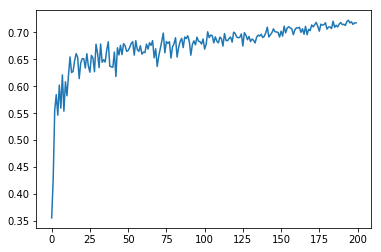

In [16]:
plt.plot(np.arange(len(acc_list)), acc_z_list)